In [ ]:
!git clone https://github.com/AI-multimodal/mcr_const
!cd mcr_const;git pull
!pip install pymcr # a package developed by NIST

In [2]:
import sys
sys.path.append("mcr_const")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, importlib
from scipy.interpolate import interp1d

from pymcr.mcr import McrAR
from pymcr.regressors import NNLS
from pymcr.constraints import ConstraintNorm
from mcr_const import ConstraintPointBelow, ConstraintFixedSegment, VarType
from mcr_const import NormMethod
from mcr_const import StoichiometricNorm

%matplotlib inline

In [4]:
lower_ti_energy, upper_ti_energy = 4960, 5030
lower_zn_energy, upper_zn_energy = 9657, 9800
ngrid_per_edge=500

In [5]:
pkg_dir_path = importlib.util.find_spec("mcr_const").submodule_search_locations[0]
data_fn = os.path.join(pkg_dir_path, "..", "data", "TiZn Multimodal K-edge Spectra.csv")
print("loading multimodal data from", data_fn)
data = np.genfromtxt(data_fn)
# Rows: 0) Energy; 1) spectrum of the 1st position; 2) spectrum of the 2nd position
# Columns: 0) Ti percentage; 1) 1st energy point of Ti spectrum; ...; 
# Columns: 316) 1st energy point of Zn spectrum; 317) 2nd energy point of Zn spectrum
data.shape

loading multimodal data from /Users/xiaohuiqu/VSCodeProjects/mcr_const/mcr_const/../data/TiZn Multimodal K-edge Spectra.csv


(101, 872)

In [6]:
# column 316 is where we separate Ti and Zn K-edge spectra.
raw_ti_ene_grid = data[0, 1:316]
raw_ti_specs = data[1:, 1:316]
raw_zn_ene_grid = data[0, 316:872]
raw_zn_specs = data[1:, 316:872]

Text(0.5, 1.0, 'Zn K-Edge Spectrum for Each Position')

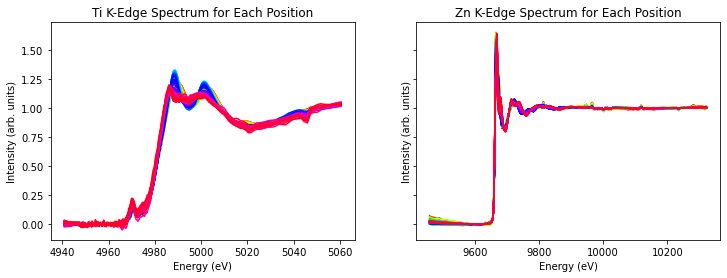

In [7]:
sns.set_palette('hsv', 100)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for spec in raw_ti_specs:
    ax1.plot(raw_ti_ene_grid, spec)
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Intensity (arb. units)')
ax1.set_title('Ti K-Edge Spectrum for Each Position')
for spec in raw_zn_specs:
    ax2.plot(raw_zn_ene_grid, spec)
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Intensity (arb. units)')
ax2.set_title('Zn K-Edge Spectrum for Each Position')

Text(0, 0.5, 'Intensity (arb. units)')

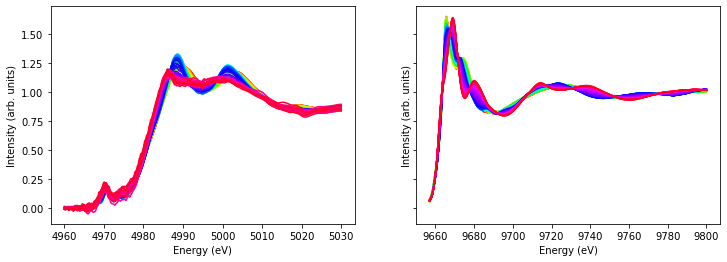

In [8]:
ti_ene_grid = np.linspace(lower_ti_energy, upper_ti_energy, ngrid_per_edge)
zn_ene_grid = np.linspace(lower_zn_energy, upper_zn_energy, ngrid_per_edge)

# Put spectrum on narrower and uniform grid
ti_specs_on_grid_unscaled = np.stack([interp1d(raw_ti_ene_grid, spec, kind='cubic')(ti_ene_grid) for spec in raw_ti_specs])
zn_specs_on_grid_unscaled = np.stack([interp1d(raw_zn_ene_grid, spec, kind='cubic')(zn_ene_grid) for spec in raw_zn_specs])

sns.set_palette('hsv', 100)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for spec in ti_specs_on_grid_unscaled:
    ax1.plot(ti_ene_grid, spec)
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Intensity (arb. units)')
for spec in zn_specs_on_grid_unscaled:
    ax2.plot(zn_ene_grid, spec)
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Intensity (arb. units)')

Text(0, 0.5, 'Ti Elemental Fraction')

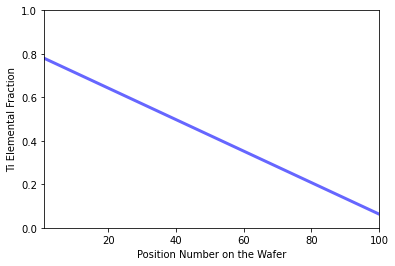

In [9]:
ti_frac = data[1:, 0]
plt.plot(np.linspace(1, 100, 100), ti_frac, c='blue', lw=3.0, alpha=0.6)
plt.ylim([0, 1])
plt.xlim([1, 100])
plt.xlabel('Position Number on the Wafer')
plt.ylabel('Ti Elemental Fraction')

Text(0.5, 1.0, 'Zn K-Edge Spectrum for Each Position')

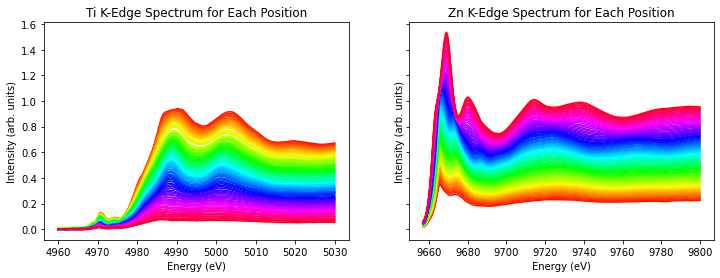

In [10]:
# scale the spectrum according to elemental fraction
ti_specs_on_grid = ti_specs_on_grid_unscaled * ti_frac[:, np.newaxis]
zn_specs_on_grid = zn_specs_on_grid_unscaled * (1.0 - ti_frac[:, np.newaxis])

# color represents the position on the material wafer
# spectrum of the same color are for the same position (sample)
sns.set_palette('hsv', 100)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for spec in ti_specs_on_grid:
    ax1.plot(ti_ene_grid, spec)
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Intensity (arb. units)')
ax1.set_title('Ti K-Edge Spectrum for Each Position')
for spec in zn_specs_on_grid:
    ax2.plot(zn_ene_grid, spec)
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Intensity (arb. units)')
ax2.set_title('Zn K-Edge Spectrum for Each Position')

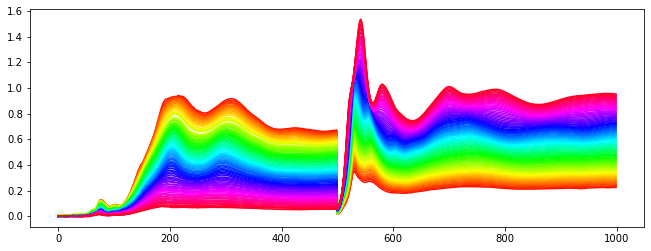

In [11]:
# Put two edges for MCR analysis

plt.figure(figsize=(11, 4))
joint_specs = np.concatenate([ti_specs_on_grid, zn_specs_on_grid], axis=1)
for spec in joint_specs:
    plt.plot(spec)

Text(0.5, 1.0, 'ZnO K-Edge Reference Spectrum')

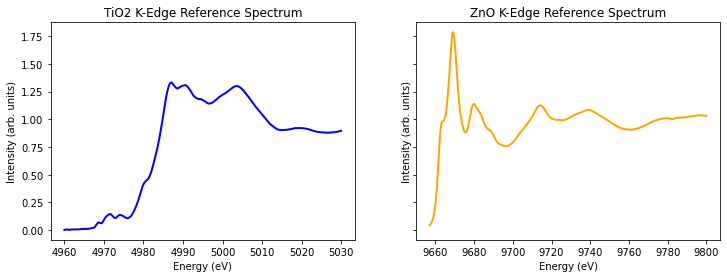

In [12]:
ti_ref_fn = os.path.join(pkg_dir_path, "..", "data", "ti_ref.csv")
ti_end_point_raw_df = pd.read_csv(ti_ref_fn, index_col=0)
ti_end_point_spec = interp1d(ti_end_point_raw_df.energy, ti_end_point_raw_df.mu)(ti_ene_grid)
zn_ref_fn = os.path.join(pkg_dir_path, "..", "data", "zn_ref.csv")
zn_end_point_raw_df = pd.read_csv(zn_ref_fn, index_col=0)
zn_end_point_spec = interp1d(zn_end_point_raw_df.energy, zn_end_point_raw_df.mu)(zn_ene_grid)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax1.plot(ti_ene_grid, ti_end_point_spec, c='blue', lw=2.0)
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('Intensity (arb. units)')
ax1.set_title('TiO2 K-Edge Reference Spectrum')
ax2.plot(zn_ene_grid, zn_end_point_spec, c='orange', lw=2.0)
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Intensity (arb. units)')
ax2.set_title('ZnO K-Edge Reference Spectrum')

Text(0, 0.5, '$\\mu$($E$)')

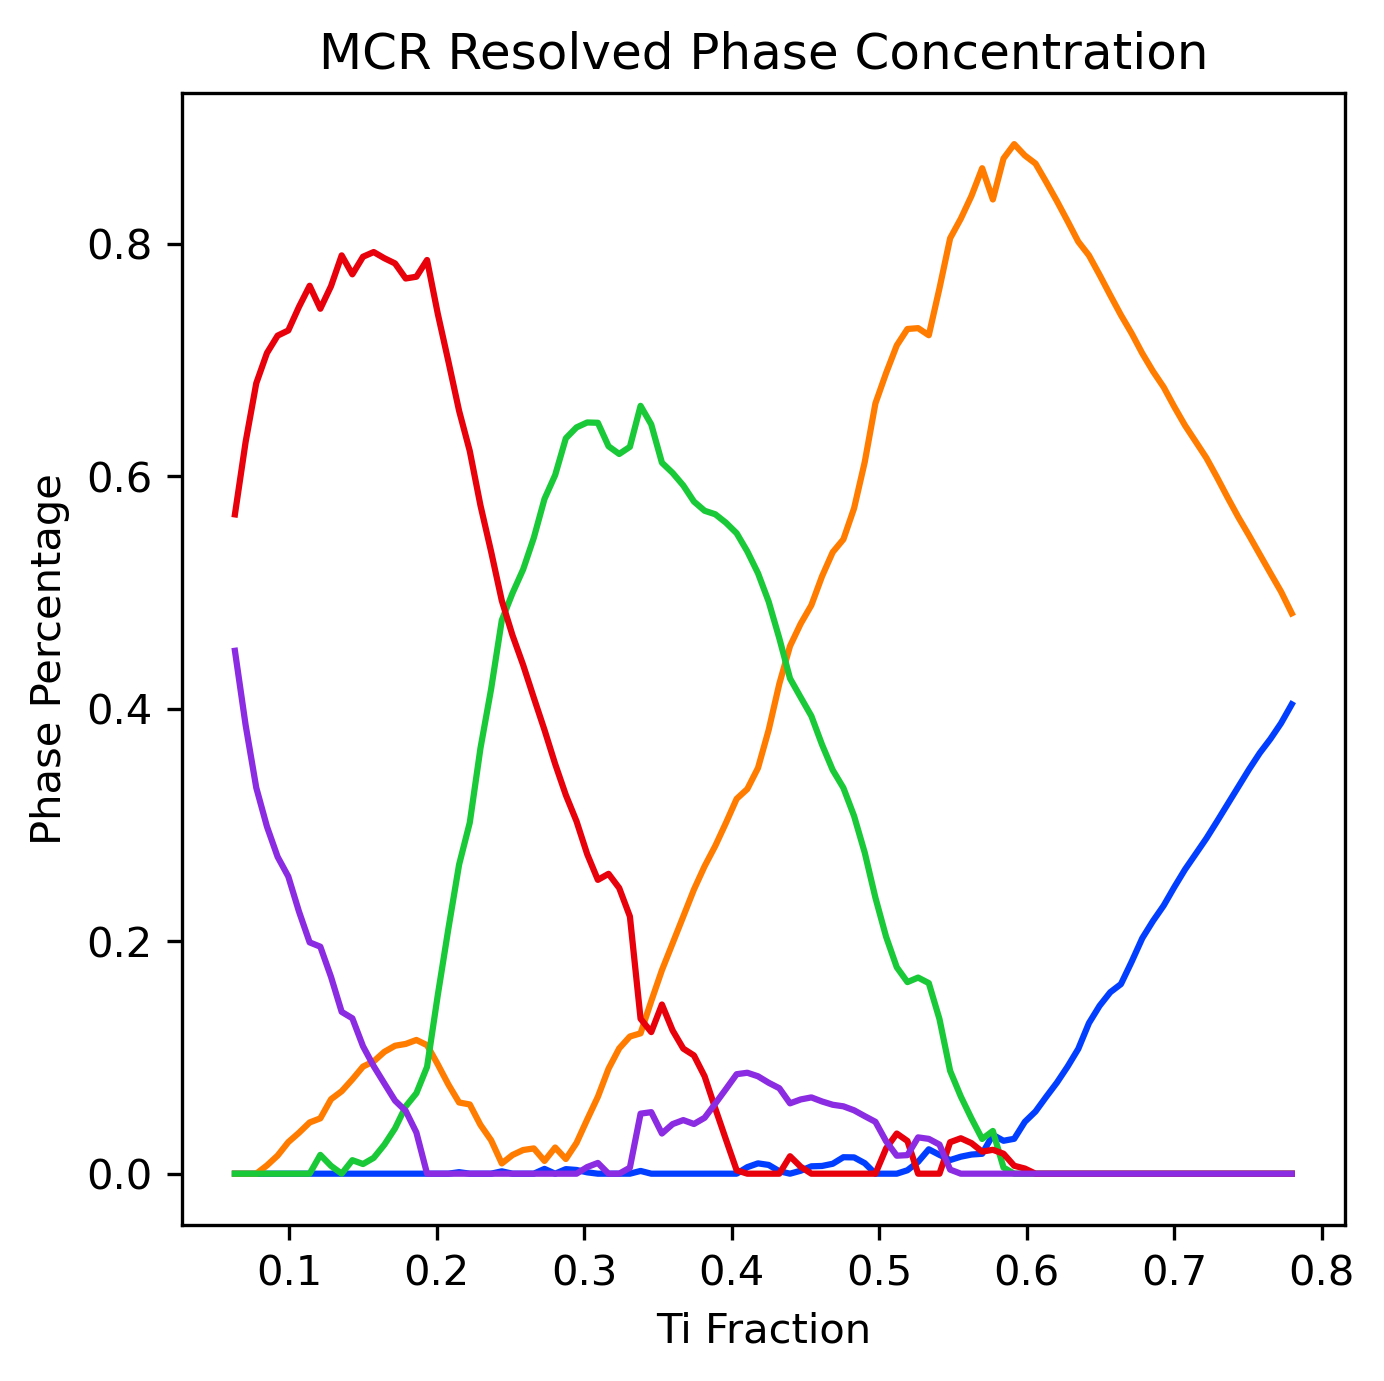

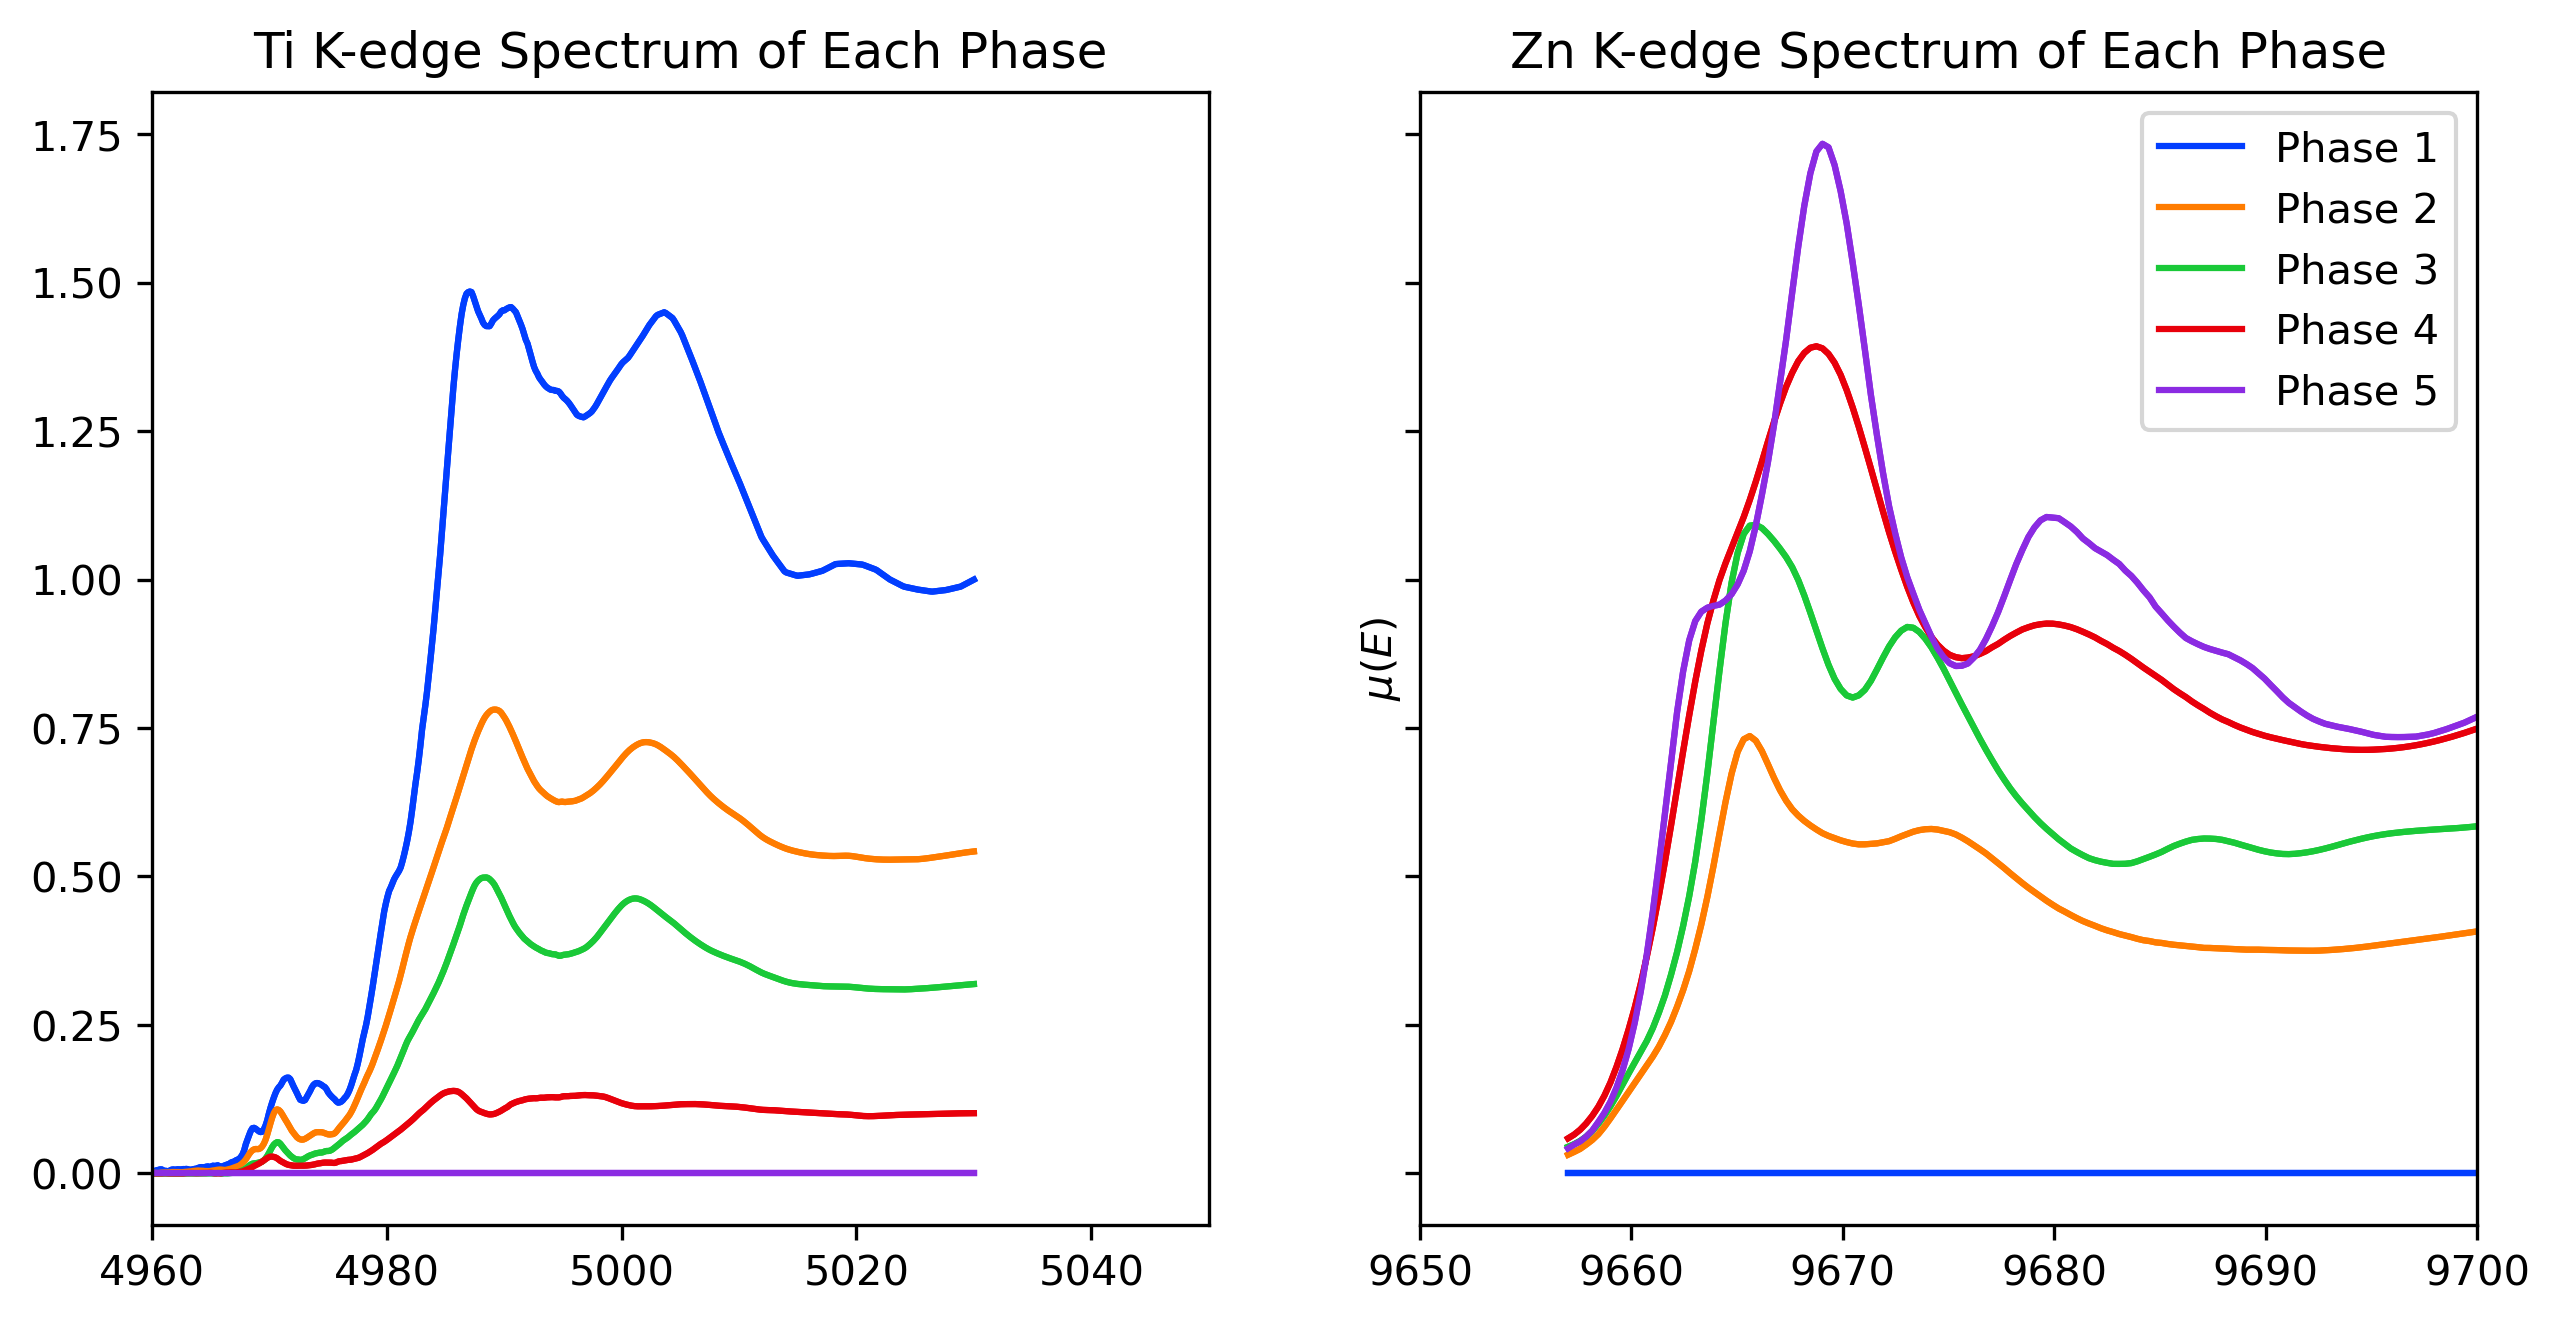

In [13]:

peak_position_guess_5_phases = [10, 30, 60, 80, 90]

spec_guess = joint_specs[peak_position_guess_5_phases]

mcrar = McrAR(c_regr=NNLS(),
              st_regr=NNLS(),
              tol_increase=1.0E2,
              max_iter=100,
              
              st_constraints=[
                  ConstraintFixedSegment.from_range(
                      i_specie=0,
                      i_ranges=[(0, ngrid_per_edge),(ngrid_per_edge, 2 * ngrid_per_edge)],
                      targets=[ti_end_point_spec,
                               np.zeros(ngrid_per_edge)],
                      var_type=VarType.SPECTRA),
                  ConstraintFixedSegment.from_range(
                      i_specie=4,
                      i_ranges=[(0, ngrid_per_edge),(ngrid_per_edge, 2 * ngrid_per_edge)],
                      targets=[np.zeros(ngrid_per_edge), zn_end_point_spec],
                      var_type=VarType.SPECTRA),
                  StoichiometricNorm(i_species=list(range(0, spec_guess.shape[0])),
                                     element_start_end_indices=[(0, ngrid_per_edge), (ngrid_per_edge, 2*ngrid_per_edge)],
                                     norm_method=NormMethod.TAIL_ONLY)
              ])


mcrar.fit(joint_specs, ST=spec_guess)
resolved_conc_combined = mcrar.C_opt_
resolved_spec_combined  = mcrar.ST_opt_
ti_mcr_specs = resolved_spec_combined [:, :ngrid_per_edge]
zn_mcr_specs = resolved_spec_combined [:, ngrid_per_edge:]

plt.figure(figsize=(5,5),dpi=300)
sns.set_palette('bright', resolved_conc_combined.shape[0])
for i, conc in enumerate(resolved_conc_combined.T):
    plt.plot(ti_frac, conc, label=f'Phase {i+1}')

title = "MCR Resolved Phase Concentration"
plt.xlabel("Ti Fraction")
plt.ylabel("Phase Percentage")
plt.title(title)

colors = sns.color_palette('bright', resolved_spec_combined.shape[0])
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=300,sharey=True)
for j_specie in range(2):
    for i, (ti_rspec, zn_rspec, color) in enumerate(zip(ti_mcr_specs, zn_mcr_specs, colors)):
        if j_specie == 0:
            label = f'Phase {i+1}'
        else:
            label = None
        ax1.plot(ti_ene_grid, ti_rspec, lw=1.5, c=color, label=label)
        ax2.plot(zn_ene_grid, zn_rspec, lw=1.5, c=color, label=label)
ax1.set_xlim(4960,5050)
ax1.set_title('Ti K-edge Spectrum of Each Phase')
ax2.set_xlim(9650,9700)
ax2.set_title('Zn K-edge Spectrum of Each Phase')
plt.legend()
plt.ylabel("$\mu$($E$)")


Text(0.5, 1.0, 'MCR Resolved Phase Composition')

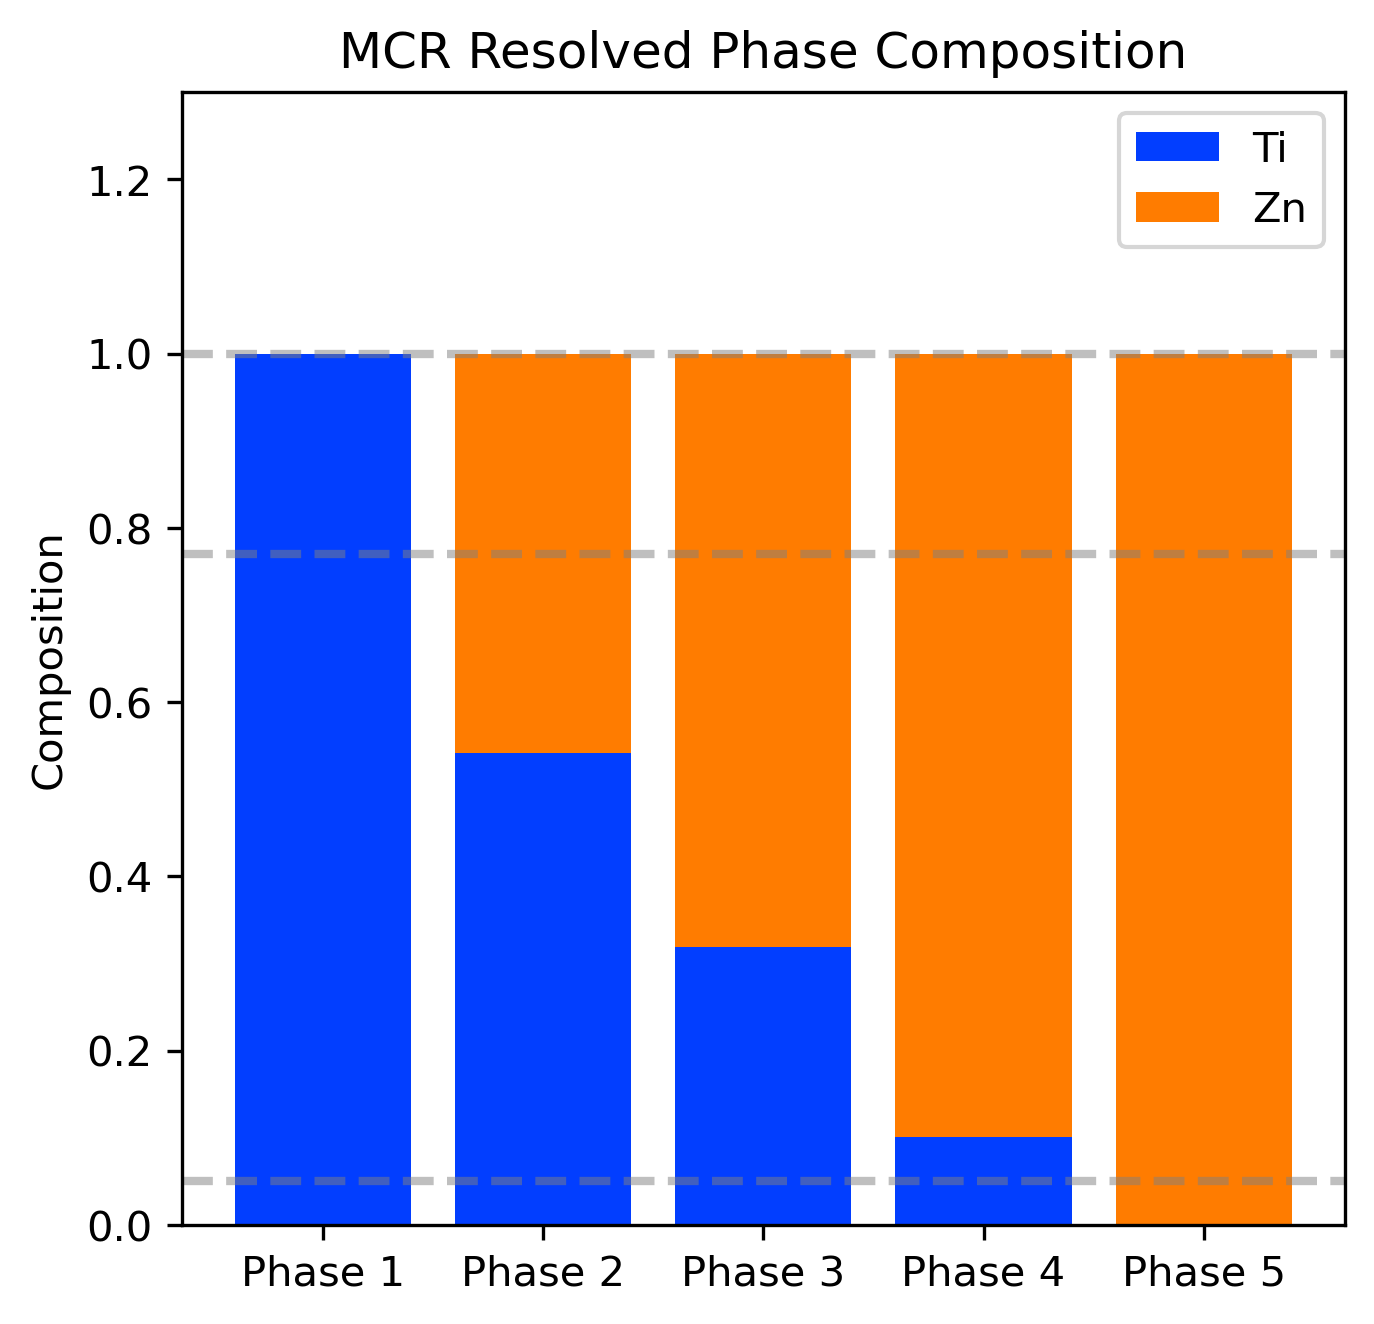

In [14]:
phase_ti_frac = ti_mcr_specs[:, -1]
phase_zn_frac = zn_mcr_specs[:, -1]

plt.figure(figsize=(5, 5), dpi=300)
phase_names = [f"Phase {i+1}" for i in range(5)]
plt.bar(phase_names, phase_ti_frac, label='Ti')
plt.bar(phase_names,
        phase_zn_frac,
        bottom=phase_ti_frac,
        label='Zn')
plt.legend()
plt.ylim([0, 1.3])
plt.axhline(1.0, c='gray', lw=2.0, ls="--", alpha=0.5)
plt.axhline(0.77, c='gray', lw=2.0, ls="--", alpha=0.5)
plt.axhline(0.05, c='gray', lw=2.0, ls="--", alpha=0.5)
# plt.xlabel("Phase Name")
plt.ylabel("Composition")
title = "MCR Resolved Phase Composition"
plt.title(title)